In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Loading the Dataset

In [2]:
file_path = '../input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'

names = ['class']
names.extend([i for i in range(1, 785)])

df = pd.read_csv(file_path, header=None, names=names)

y_full = df['class']
x_full = df.drop('class', axis=1).values.reshape(-1, 28, 28, 1)

The dataset contains 28x28 grayscale images flattened into 784 columns (pixels).

class column: Label (0-25 for A-Z).

1-784 columns: Pixel values.

# Splitting Dataset

In [3]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(x_full, y_full):
    x_train_full, y_train_full = x_full[train_idx], y_full.iloc[train_idx].values
    x_test, y_test = x_full[test_idx], y_full.iloc[test_idx].values

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.1,
    stratify=y_train_full,
    random_state=42
)

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.20,
    rescale=1./255,
)

In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [6]:
train_loader = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

In [7]:
valid_loader = valid_datagen.flow(
    x_valid, y_valid,
    batch_size=32,
    shuffle=False
)

In [8]:
test_loader = test_datagen.flow(
    x_test, y_test,
    batch_size=32,
    shuffle=False
)

# Building the VGG19 from Scratch

In [9]:
def build_vgg19(input_shape=(28,28,1), num_classes=26):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
    # Block 2
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
    # Block 3
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
    
    # Flatten and Classification
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))  # smaller dense layer
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [10]:
vgg19 = build_vgg19()
vgg19.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763921305.264868    1387 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763921305.265494    1387 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,190,490 (12.17 MB)

 Trainable params: 3,190,490 (12.17 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
vgg19.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = vgg19.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=50,
    callbacks=[early_stop],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1763921308.829015    1441 service.cc:148] XLA service 0x7e58dc012e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763921308.829079    1441 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763921308.829086    1441 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763921309.244538    1441 cuda_dnn.cc:529] Loaded cuDNN version 90300


   8/8381 ━━━━━━━━━━━━━━━━━━━━ 2:19 17ms/step - accuracy: 0.1127 - loss: 3.1848 

I0000 00:00:1763921313.023505    1441 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8381/8381 ━━━━━━━━━━━━━━━━━━━━ 112s 13ms/step - accuracy: 0.7865 - loss: 0.7458 - val_accuracy: 0.9775 - val_loss: 0.0948
Epoch 2/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9656 - loss: 0.1427 - val_accuracy: 0.9775 - val_loss: 0.0996
Epoch 3/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 102s 12ms/step - accuracy: 0.9688 - loss: 0.1328 - val_accuracy: 0.9842 - val_loss: 0.0689
Epoch 4/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9696 - loss: 0.1303 - val_accuracy: 0.9832 - val_loss: 0.0718
Epoch 5/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9698 - loss: 0.1287 - val_accuracy: 0.9832 - val_loss: 0.0721
Epoch 6/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9691 - loss: 0.1348 - val_accuracy: 0.9833 - val_loss: 0.0699
Epoch 7/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9697 - loss: 0.1345 - val_accuracy: 0.9825 - val_loss: 0.0737
Epoch 8/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9678 - lo

In [14]:
test_loss, test_acc = vgg19.evaluate(test_loader)
print("Test Accuracy =", test_acc)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9828 - loss: 0.0713
Test Accuracy = 0.9835684895515442


In [15]:
y_pred_probs = vgg19.predict(test_loader)
y_pred = np.argmax(y_pred_probs, axis=1)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


In [18]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9836


## Precision, Recall, F1-score 

In [19]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9791
Recall: 0.9774
F1-score: 0.9782


## Confusion Matrix

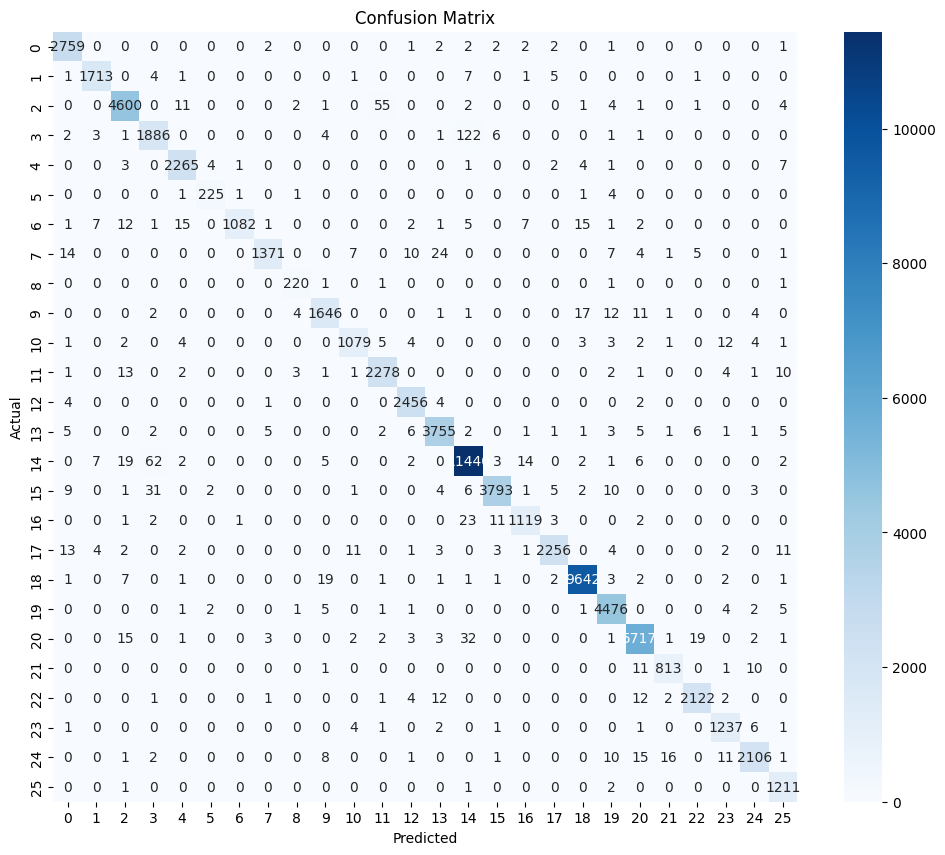

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC & AUC for multi-class

In [27]:
# Convert labels to one-hot
y_test_bin = label_binarize(y_test, classes=range(26))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

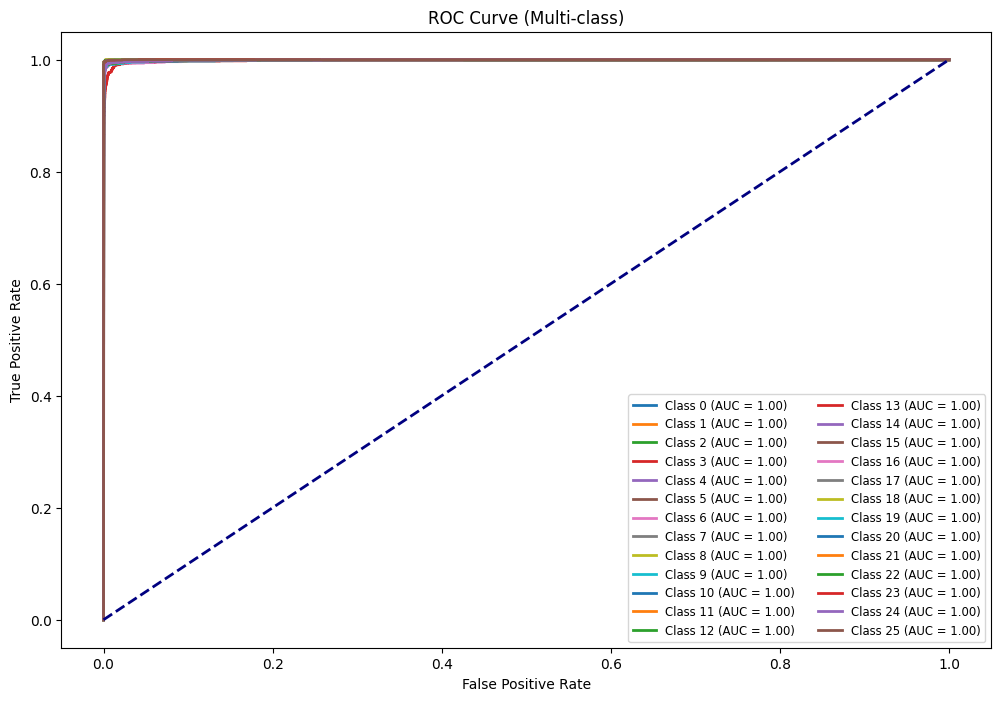

In [28]:
# Plot ROC curve for all classes
plt.figure(figsize=(12,8))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.show()